## Rank2LaptimeDifference

rank prediction by elapsed time difference in a race

Since use laptime2rank is not very successful, and predicting rank directly is not as well, to combine the real value regression into rank prediction task might be a solution.

And, differences of the elapsed time among the cars takes correlations into input, that brings more chances to success.

time_behind_leader is accurate when the car runs in the same lap as the leader does, otherwise, the time is truncted. To get accurate differences, using elapsed time is needed.


In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mxnet as mx
from mxnet import gluon
import pickle
import json
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from pathlib import Path
from gluonts.model.deepar import DeepAREstimator
from gluonts.model.deep_factor import DeepFactorEstimator
from gluonts.model.deepstate import DeepStateEstimator
from gluonts.trainer import Trainer
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator, MultivariateEvaluator
from gluonts.distribution.multivariate_gaussian import MultivariateGaussianOutput
from gluonts.model.predictor import Predictor
from gluonts.model.prophet import ProphetPredictor
from gluonts.model.r_forecast import RForecastPredictor
from indycar.model.NaivePredictor import NaivePredictor
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
INFO:root:Using GPU
ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [2]:
import os
os.getcwd()

'/scratch/hpda/indycar/notebook/11.OracleRank'

### load time&score data

In [3]:
#
# parameters
#
#year = '2017'
year = '2018'
#event = 'Toronto'
#https://www.racing-reference.info/season-stats/2018/O/#
events_totalmiles=[256,500,372,268,500,310]
events_laplen = [1.022,2.5,1.5,0.894,2.5,1.25]
events = ['Phoenix','Indy500','Texas','Iowa','Pocono','Gateway']
#events = ['Gateway']

#events = ['Indy500']
#events = ['Phoenix']
events_id={key:idx for idx, key in enumerate(events)}

In [4]:
def load_data(event, year):
    inputfile = '../data/final/C_'+ event +'-' + year + '-final.csv'
    outputprefix = year +'-' + event + '-'
    dataset = pd.read_csv(inputfile)
    #dataset.info(verbose=True)    
    
    final_lap = max(dataset.completed_laps)
    total_laps = final_lap + 1

    # get records for the cars that finish the race
    completed_car_numbers= dataset[dataset.completed_laps == final_lap].car_number.values
    completed_car_count = len(completed_car_numbers)

    print('count of completed cars:', completed_car_count)
    print('completed cars:', completed_car_numbers)

    #make a copy
    alldata = dataset.copy()
    dataset = dataset[dataset['car_number'].isin(completed_car_numbers)]
    rankdata = alldata.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')
    
    cldata = make_cl_data(dataset)
    acldata = make_cl_data(alldata)

    return alldata, rankdata, acldata

# make indy car completed_laps dataset
# car_number, completed_laps, rank, elapsed_time, rank_diff, elapsed_time_diff 
def make_cl_data(dataset):

    # pick up data with valid rank
    rankdata = dataset.rename_axis('MyIdx').sort_values(by=['elapsed_time','MyIdx'], ascending=True)
    rankdata = rankdata.drop_duplicates(subset=['car_number', 'completed_laps'], keep='first')

    # resort by car_number, lap
    uni_ds = rankdata.sort_values(by=['car_number', 'completed_laps', 'elapsed_time'], ascending=True)    
    #uni_ds = uni_ds.drop(["unique_id", "best_lap", "current_status", "track_status", "lap_status",
    #                  "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
    #                  "last_pitted_lap","start_position","laps_led"], axis=1)
    
    uni_ds = uni_ds.drop(["unique_id", "best_lap", 
                      "laps_behind_leade","laps_behind_prec","overall_rank","pit_stop_count",
                      "last_pitted_lap","start_position","laps_led"], axis=1)
        
    carnumber = set(uni_ds['car_number'])
    print('cars:', carnumber)
    print('#cars=', len(carnumber))
   
    # faster solution , uni_ds already sorted by car_number and lap
    uni_ds['rank_diff'] = uni_ds['rank'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['rank_diff'][mask] = 0
    
    uni_ds['time_diff'] = uni_ds['elapsed_time'].diff()
    mask = uni_ds.car_number != uni_ds.car_number.shift(1)
    uni_ds['time_diff'][mask] = 0
    
    #df = uni_ds[['car_number','completed_laps','rank','elapsed_time','rank_diff','time_diff']]
    df = uni_ds[['car_number','completed_laps','rank','elapsed_time',
                 'rank_diff','time_diff',"current_status", "track_status", "lap_status"]]
    
    return df

In [5]:
stagedata = {}
global_carids = {}
traindata = None
cur_carid = 0
for event in events:
    #alldata, rankdata, acldata, flagdata
    stagedata[event] = load_data(event, year)
    
    alldata, rankdata, acldata = stagedata[event]
    carlist = set(acldata['car_number'])
    laplist = set(acldata['completed_laps'])
    print('%s: carno=%d, lapnum=%d'%(event, len(carlist), len(laplist)))

    #build the carid map
    for car in carlist:
        if car not in global_carids:
            global_carids[car] = cur_carid
            cur_carid += 1

count of completed cars: 11
completed cars: [ 1  6 27  9 28  5 20 14 15 22 30]
cars: {1, 5, 6, 9, 14, 15, 20, 22, 27, 28, 30}
#cars= 11
cars: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 32, 59, 88, 98}
#cars= 23


/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/ipykernel_launcher.py:57: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Phoenix: carno=23, lapnum=251
count of completed cars: 18
completed cars: [12 20  9 27 28 22 29  1  6 15 66 98  4 88 25 60 64 23]
cars: {64, 1, 66, 98, 4, 6, 9, 12, 60, 15, 20, 22, 23, 88, 25, 27, 28, 29}
#cars= 18
cars: {1, 3, 4, 6, 7, 9, 10, 12, 13, 14, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 59, 60, 64, 66, 88, 98}
#cars= 33
Indy500: carno=33, lapnum=201
count of completed cars: 9
completed cars: [ 9 22 27  5 28 15 30 18 10]
cars: {5, 9, 10, 15, 18, 22, 27, 28, 30}
#cars= 9
cars: {1, 3, 4, 5, 6, 7, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30, 47, 55, 57, 59, 60, 68, 73, 83, 88, 98}
#cars= 32
Texas: carno=32, lapnum=249
count of completed cars: 5
completed cars: [ 5 21 30  1  6]
cars: {1, 5, 6, 21, 30}
#cars= 5
cars: {1, 4, 5, 6, 9, 10, 12, 14, 15, 18, 19, 20, 21, 22, 23, 26, 27, 28, 30, 59, 88, 98}
#cars= 22
Iowa: carno=22, lapnum=301
count of completed cars: 4
completed cars: [27 12  9 18]
cars: {9, 18, 27, 12}
#cars= 4
cars: {1, 4, 5, 

In [6]:
event='Indy500'
alldata, rankdata, acldata = stagedata[event]

In [18]:
rankdata[rankdata['completed_laps']==2]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
115,1,20,0,2,82.7118,40.7746,T,40.7746,2,0.0000,...,0.0000,0,1,40.7746,Active,G,0,0,1,2
148,2,12,2,2,83.1845,41.0360,T,41.0360,2,0.4727,...,0.4727,0,2,41.0360,Active,G,0,0,3,0
149,3,22,1,2,83.2361,41.0209,T,41.0209,2,0.5243,...,0.0516,0,3,41.0209,Active,G,0,0,2,0
150,4,1,3,2,83.8813,41.0984,T,41.0984,2,1.1695,...,0.6452,0,4,41.0984,Active,G,0,0,4,0
152,5,18,4,2,84.2300,40.9646,T,40.9646,2,1.5182,...,0.3487,0,5,40.9646,Active,G,0,0,5,0
153,6,14,9,2,84.7185,40.7424,T,40.7424,2,2.0067,...,0.4885,0,6,40.7424,Active,G,0,0,A,0
156,7,21,5,2,85.2691,41.7464,T,41.7464,2,2.5573,...,0.5506,0,7,41.7464,Active,G,0,0,6,0
157,8,3,7,2,85.4770,41.2297,T,41.2297,2,2.7652,...,0.2079,0,8,41.2297,Active,G,0,0,8,0
159,9,9,8,2,85.9834,41.2504,T,41.2504,2,3.2716,...,0.5064,0,9,41.2504,Active,G,0,0,9,0


In [17]:
rankdata[rankdata['elapsed_time']<=27]

,rank,car_number,unique_id,completed_laps,elapsed_time,last_laptime,lap_status,best_laptime,best_lap,time_behind_leader,...,time_behind_prec,laps_behind_prec,overall_rank,overall_best_laptime,current_status,track_status,pit_stop_count,last_pitted_lap,start_position,laps_led
MyIdx,,,,,,,,,,,,,,,,,,,,,
0,1,20,0,0,0.0000,91.4880,T,0.0,0,0.0000,...,0.0000,0,1,0.0,Active,G,0,0,1,0
1,2,22,1,0,0.1120,91.0722,T,0.0,0,0.1120,...,0.1120,0,2,0.0,Active,G,0,0,2,0
2,3,12,2,0,0.2247,90.2903,T,0.0,0,0.2247,...,0.1127,0,3,0.0,Active,G,0,0,3,0
4,5,18,4,0,0.3152,89.3432,T,0.0,0,0.3152,...,0.0000,0,5,0.0,Active,G,0,0,5,0
3,4,1,3,0,0.4150,89.7686,T,0.0,0,0.4150,...,0.1903,0,4,0.0,Active,G,0,0,4,0
5,6,21,5,0,0.4757,88.2831,T,0.0,0,0.4757,...,0.1605,0,6,0.0,Active,G,0,0,6,0
6,9,9,8,0,0.9168,85.0895,T,0.0,0,0.9168,...,0.9168,0,9,0.0,Active,G,0,0,9,0
8,8,3,7,0,0.9523,85.8539,T,0.0,0,0.9523,...,0.0000,0,8,0.0,Active,G,0,0,8,0
7,7,13,6,0,0.9676,87.6776,T,0.0,0,0.9676,...,0.4919,0,7,0.0,Active,G,0,0,7,0


In [11]:
rankdata.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5769 entries, 0 to 18498
Data columns (total 21 columns):
rank                    5769 non-null int64
car_number              5769 non-null int64
unique_id               5769 non-null object
completed_laps          5769 non-null int64
elapsed_time            5769 non-null float64
last_laptime            5769 non-null float64
lap_status              5769 non-null object
best_laptime            5769 non-null float64
best_lap                5769 non-null object
time_behind_leader      5769 non-null float64
laps_behind_leade       5769 non-null object
time_behind_prec        5769 non-null float64
laps_behind_prec        5769 non-null object
overall_rank            5769 non-null object
overall_best_laptime    5769 non-null float64
current_status          5769 non-null object
track_status            5769 non-null object
pit_stop_count          5769 non-null object
last_pitted_lap         5769 non-null object
start_position          5769 non-n

### load prediction data

In [16]:
# start from here
import pickle
with open('laptime_rank-oracle-%s.pickle'%year, 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    global_carids, laptime_data = pickle.load(f, encoding='latin1') 

In [17]:

def nan_helper(y):
    """Helper to handle indices and logical indices of NaNs.

    Input:
        - y, 1d numpy array with possible NaNs
    Output:
        - nans, logical indices of NaNs
        - index, a function, with signature indices= index(logical_indices),
          to convert logical indices of NaNs to 'equivalent' indices
    Example:
        >>> # linear interpolation of NaNs
        >>> nans, x= nan_helper(y)
        >>> y[nans]= np.interp(x(nans), x(~nans), y[~nans])
    """

    return np.isnan(y), lambda z: z.nonzero()[0]

def test_flag(a, bitflag):
    return (a & bitflag) ==  bitflag

#
# remove NaN at the tail
# there should be no nans in the middle of the ts
COL_LAPTIME=0
COL_RANK=1
COL_TRACKSTATUS=2
COL_LAPSTATUS=3
MODE_ORACLE = 0
MODE_NOLAP = 1
MODE_NOTRACK = 2
MODE_TESTZERO = 4
MODE_TESTCURTRACK = 8
#MODE_STR={MODE_ORACLE:'oracle', MODE_NOLAP:'nolap',MODE_NOTRACK:'notrack',MODE_TEST:'test'}

def make_dataset(runs, prediction_length, freq, 
                       useeid = False,
                       run_ts=COL_LAPTIME, 
                       train_ratio = 0.8,
                       use_global_dict = True,
                       oracle_mode = MODE_ORACLE,test_cars = []
                ):
    """
    split the ts to train and test part by the ratio
    
    oracle_mode: false to simulate prediction in real by 
        set the covariates of track and lap status as nan in the testset
            
    
    """    
    start = pd.Timestamp("01-01-2019", freq=freq)  # can be different for each time series

    train_set = []
    test_set = []
    
    #select run
    if runs>=0:
        _laptime_data = [laptime_data[runs].copy()]
    else:
        _laptime_data = laptime_data.copy()
    
   
    #_data: eventid, carids, datalist[carnumbers, features, lapnumber]->[laptime, rank, track, lap]]
    for _data in _laptime_data:
        _train = []
        _test = []
        
        #statistics on the ts length
        ts_len = [ _entry.shape[1] for _entry in _data[2]]
        train_len = int(np.max(ts_len) * train_ratio)
        
        print(f'====event:{events[_data[0]]}, train_len={train_len}, max_len={np.max(ts_len)}, min_len={np.min(ts_len)}')
                
        # process for each ts
        for rowid in range(_data[2].shape[0]):
            # rec[features, lapnumber] -> [laptime, rank, track_status, lap_status]]
            rec = _data[2][rowid].copy()
            
            #remove nan(only tails)
            nans, x= nan_helper(rec[run_ts,:])
            nan_count = np.sum(nans)             
            rec = rec[:, ~np.isnan(rec[run_ts,:])]
            
            # remove short ts
            totallen = rec.shape[1]
            if ( totallen < train_len + prediction_length):
                print(f'a short ts: carid={_data[1][rowid]}，len={totallen}')
                continue                
            
            if use_global_dict:
                carno = _data[1][rowid]
                carid = global_carids[_data[1][rowid]]
            else:
                #simulation dataset, todo, fix the carids as decoder
                carno = rowid
                carid = rowid
                
            #eval on carids
            if test_cars and (carno not in test_cars):
                continue
                
            if useeid:
                static_cat = [carid, _data[0]]    
            else:
                static_cat = [carid]    
                
            # selection of features
            if test_flag(oracle_mode, MODE_NOTRACK):                
                rec[COL_TRACKSTATUS, :] = 0
            if test_flag(oracle_mode, MODE_NOLAP):                
                rec[COL_LAPSTATUS, :] = 0
                
            # split and add to dataset record
            _train.append({'target': rec[run_ts,:train_len].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': static_cat,
                            'feat_dynamic_real': [rec[COL_TRACKSTATUS,:train_len],
                                   rec[COL_LAPSTATUS,:train_len]]
                          }
                          )
            
            # multiple test ts(rolling window as half of the prediction_length)
            test_rec_cnt = 0
            for endpos in range(totallen, train_len+prediction_length, 
                                -int(prediction_length/2)):
                
                track_rec = rec[COL_TRACKSTATUS, :endpos].copy()
                lap_rec = rec[COL_LAPSTATUS, :endpos].copy()
                
                # test mode
                if test_flag(oracle_mode, MODE_TESTCURTRACK):
                    # since nan does not work, use cur-val instead
                    track_rec[-prediction_length:] = track_rec[-prediction_length - 1]
                    #track_rec[-prediction_length:] = random.randint(0,1)
                    #lap_rec[-prediction_length:] = lap_rec[-prediction_length - 1]
                    lap_rec[-prediction_length:] = 0
                elif test_flag(oracle_mode, MODE_TESTZERO):
                    #set prediction part as nan
                    #track_rec[-prediction_length:] = np.nan
                    #lap_rec[-prediction_length:] = np.nan
                    track_rec[-prediction_length:] = 0
                    lap_rec[-prediction_length:] = 0                    
                
                _test.append({'target': rec[run_ts,:endpos].astype(np.float32), 
                            'start': start, 
                            'feat_static_cat': static_cat,
                            'feat_dynamic_real': [track_rec,lap_rec]
                            #'feat_dynamic_real': [rec[COL_TRACKSTATUS,:endpos],
                            #       rec[COL_LAPSTATUS,:endpos]] 
                             }
                          )   
                test_rec_cnt += 1
            
            #add one ts
            print(f'carno:{carno}, totallen:{totallen}, nancount:{nan_count}, test_reccnt:{test_rec_cnt}')

        train_set.extend(_train)
        test_set.extend(_test)

    print(f'train len:{len(train_set)}, test len:{len(test_set)}')
    
    train_ds = ListDataset(train_set, freq=freq)
    test_ds = ListDataset(test_set, freq=freq)    
    
    return train_ds, test_ds, train_set, test_set

def save_dataset(datafile,freq, prediction_length, cardinality, train_ds, test_ds):
    with open(datafile, 'wb') as f:
        #pack [global_carids, laptime_data]
        savedata = [freq, prediction_length, cardinality, train_ds, test_ds]
        #savedata = [freq, train_set, test_set]
        # Pickle the 'data' dictionary using the highest protocol available.
        pickle.dump(savedata, f, pickle.HIGHEST_PROTOCOL)

In [32]:
# construct long prediction result
def plot_prob_forecasts_ex(ts_entry, forecast_entry, outputfile):

    plot_length = int(forecast_entry[0].samples.shape[1] *2) 
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    figcnt = len(ts_entry)
    for idx in range(figcnt):
        fig, axs = plt.subplots(1, 1, figsize=(20, 7))
        #ts_entry[idx][-plot_length:].plot(ax=axs)  # plot the time series
        #forecast_entry[idx].plot(prediction_intervals=prediction_intervals, color='g')
        ts_entry[idx].iloc[-plot_length:,0].plot(ax=axs, linewidth=1, marker='.')  # plot the time series
        forecast_entry[idx].copy_dim(0).plot(prediction_intervals=prediction_intervals, color='g')
        
        plt.grid(which="both")
        plt.legend(legend, loc="upper left")
        plt.savefig(outputfile + '-%d.pdf'%idx)
        plt.show()
        


def long_predict(output):
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)
    newsamples = np.zeros((2*nsample, last_start - first_start + npredict))

    blockid = 0
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start
        #copy sample to block
        newsamples[nsample*blockid: nsample*blockid + nsample, pos:pos + npredict] = forecasts[idx].samples

        blockid = (blockid + 1) % 2

    #first block
    newsamples[nsample*blockid: nsample*blockid + nsample, 0:0 + npredict] = forecasts[-1].samples

    #last block
    blockid = 1
    newsamples[nsample*blockid: nsample*blockid + nsample, last_start- first_start:last_start- first_start + npredict] = forecasts[0].samples

    target.samples = newsamples

    plot_prob_forecasts_ex([tss[0]],[target],output)
    
    #evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    
    
    print(json.dumps(agg_metrics, indent=4))    
    
    return target

In [23]:
cardinality = [len(global_carids)]
test_cars = [12]
test_event = 'Indy500'
save_prefix = 'test-' + test_event + '_'.join([str(x) for x in test_cars])
outputfile = 'output'

#model configure
ueseid = False
interpolate = False
ipstr = '' if interpolate else '-noip'
prediction_length = 5
freq = "1min"

evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

train_ds, test_ds,_,_ = make_dataset(events_id[test_event], prediction_length,freq, oracle_mode=MODE_NOLAP,
                                         test_cars=test_cars)

====event:Indy500, train_len=160, max_len=200, min_len=200
a short ts: carid=3，len=146
a short ts: carid=10，len=57
carno:12, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=13，len=67
a short ts: carid=18，len=137
a short ts: carid=24，len=154
a short ts: carid=30，len=46
a short ts: carid=32，len=110
a short ts: carid=33，len=46
train len:1, test len:18


INFO:root:Using GPU


tss len=18, forecasts len=18
161 195
sampel# x predictlen:  100 5


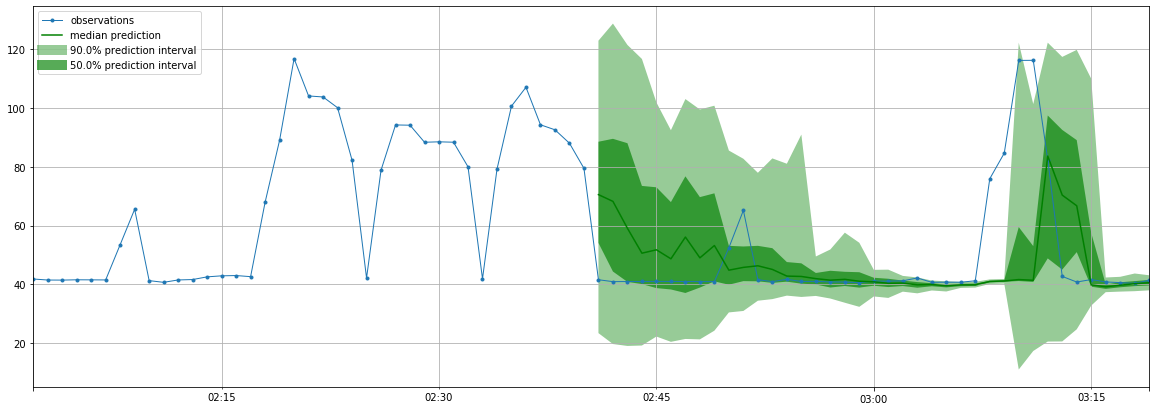

Running evaluation: 100%|██████████| 18/18 [00:00<00:00, 30.24it/s]

{
    "MSE": 412.5482541296217,
    "abs_error": 1006.0013847351074,
    "abs_target_sum": 4451.16242980957,
    "abs_target_mean": 49.457360331217444,
    "seasonal_error": 5.9303422492610585,
    "MASE": 1.9123014794460849,
    "sMAPE": 0.18826961663419736,
    "MSIS": 33.472077046324124,
    "QuantileLoss[0.1]": 292.3384185791016,
    "Coverage[0.1]": 0.022222222222222223,
    "QuantileLoss[0.5]": 1006.001392364502,
    "Coverage[0.5]": 0.5444444444444445,
    "QuantileLoss[0.9]": 968.6195861816406,
    "Coverage[0.9]": 0.7666666666666667,
    "RMSE": 20.31128391140308,
    "NRMSE": 0.41068273307305114,
    "ND": 0.2260086888759407,
    "wQuantileLoss[0.1]": 0.0656768705229228,
    "wQuantileLoss[0.5]": 0.22600869058996365,
    "wQuantileLoss[0.9]": 0.21761047848866752,
    "mean_wQuantileLoss": 0.16976534653385134,
    "MAE_Coverage": 0.0851851851851852
}


In [33]:
#load predictor
model='deepAR-laptime-indy-f1min-t5-e1000-r1'
modeldir = '../models/' + model
predictor =  Predictor.deserialize(Path(modeldir))

target = long_predict('deepAR-laptime-t5')

INFO:root:Using GPU


tss len=18, forecasts len=18
161 195
sampel# x predictlen:  100 5


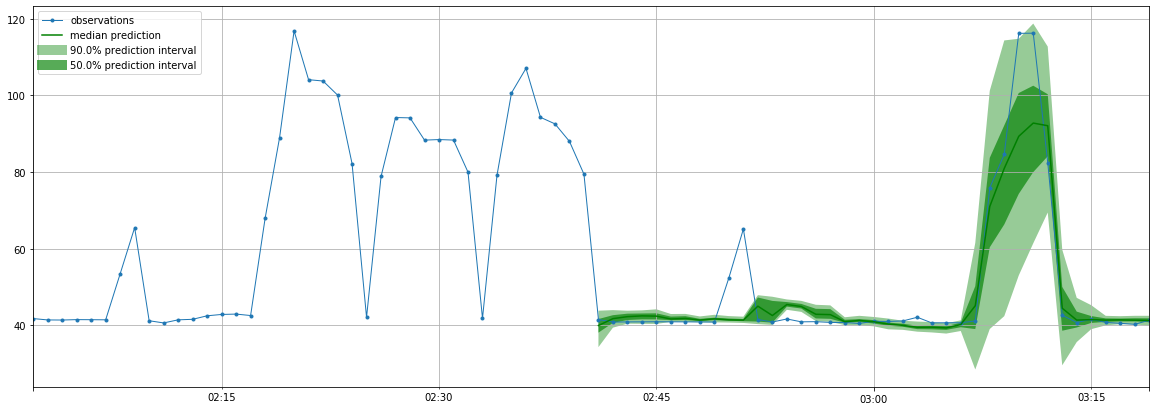

Running evaluation: 100%|██████████| 18/18 [00:00<00:00, 18.20it/s]

{
    "MSE": 58.55482819875081,
    "abs_error": 337.9299736022949,
    "abs_target_sum": 4451.16242980957,
    "abs_target_mean": 49.457360331217444,
    "seasonal_error": 5.9303422492610585,
    "MASE": 0.6417131362263733,
    "sMAPE": 0.06281687277295246,
    "MSIS": 12.453982978271117,
    "QuantileLoss[0.1]": 176.7425594329834,
    "Coverage[0.1]": 0.26666666666666666,
    "QuantileLoss[0.5]": 337.9299736022949,
    "Coverage[0.5]": 0.6000000000000001,
    "QuantileLoss[0.9]": 273.78369827270507,
    "Coverage[0.9]": 0.8,
    "RMSE": 7.6521126624449805,
    "NRMSE": 0.15472141277250848,
    "ND": 0.07591948820810662,
    "wQuantileLoss[0.1]": 0.03970705680146226,
    "wQuantileLoss[0.5]": 0.07591948820810662,
    "wQuantileLoss[0.9]": 0.06150835935331573,
    "mean_wQuantileLoss": 0.05904496812096154,
    "MAE_Coverage": 0.12222222222222223
}


In [29]:
#load predictor
model='deepAR-Oracle-laptime-indy-f1min-t5-e1000-r1'
modeldir = '../models/' + model
predictor =  Predictor.deserialize(Path(modeldir))

target = long_predict('deepAR-Oracle-laptime-t5')

/scratch/hpda/anaconda3/envs/gluonts/lib/python3.6/site-packages/gluonts/model/r_forecast/_predictor.py:191: FutureWarning: Addition/subtraction of integers and integer-arrays to Timestamp is deprecated, will be removed in a future version.  Instead of adding/subtracting `n`, use `n * self.freq`
  + data["target"].shape[0]


tss len=18, forecasts len=18
161 195
sampel# x predictlen:  100 5


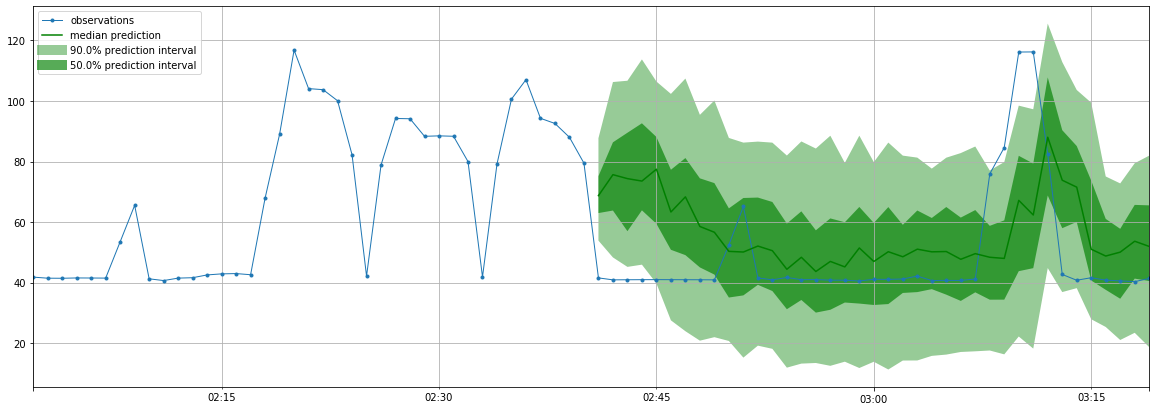

Running evaluation: 100%|██████████| 18/18 [00:00<00:00, 32.87it/s]

{
    "MSE": 419.9001642493067,
    "abs_error": 1390.3938364013848,
    "abs_target_sum": 4451.16242980957,
    "abs_target_mean": 49.457360331217444,
    "seasonal_error": 5.9303422492610585,
    "MASE": 2.6192426640218063,
    "sMAPE": 0.27501087142294195,
    "MSIS": 26.324406197929754,
    "QuantileLoss[0.1]": 489.9751426760543,
    "Coverage[0.1]": 0.14444444444444443,
    "QuantileLoss[0.5]": 1390.3938364013848,
    "Coverage[0.5]": 0.8111111111111111,
    "QuantileLoss[0.9]": 826.9231872160624,
    "Coverage[0.9]": 0.911111111111111,
    "RMSE": 20.49146564424582,
    "NRMSE": 0.4143259063365666,
    "ND": 0.3123664567012596,
    "wQuantileLoss[0.1]": 0.11007801903491005,
    "wQuantileLoss[0.5]": 0.3123664567012596,
    "wQuantileLoss[0.9]": 0.18577690665209892,
    "mean_wQuantileLoss": 0.20274046079608954,
    "MAE_Coverage": 0.12222222222222216
}


In [34]:
predictor =  RForecastPredictor(method_name='arima',freq= freq, 
                                prediction_length = prediction_length,trunc_length=200)

target = long_predict('arima-laptime')

### laptim2rank 

In [ ]:
event='Indy500'
alldata, rankdata, acldata = stagedata[event]

In [35]:
def predict():
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=test_ds,  # test dataset
        predictor=predictor,  # predictor
        num_samples=100,  # number of sample paths we want for evaluation
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)
    print(f'tss len={len(tss)}, forecasts len={len(forecasts)}')
    
    return tss, forecasts
    
    
def laptime2rank(output):
    """
    input:
        test_ds
        stagedata: alldata, rankdata, acldata = stagedata[event]
        tss, forecasts
    """
    
    def get_start(idx):
        td = forecasts[idx].start_date - start_time
        return td.days*24*60 + td.seconds//60
    
    # input: tss, forecasts
    start_time, row = next(tss[0].iterrows())

    first_start = get_start(-1)
    last_start = get_start(0)
    print(first_start, last_start)    
    
    import copy
    target = copy.deepcopy(forecasts[-1])

    #100, 10
    nsample, npredict = target.samples.shape
    print('sampel# x predictlen: ', nsample, npredict)

    blockid = 0
    for idx in range(len(forecasts)):
        #copy samples
        start_pos = get_start(idx)

        pos = start_pos - first_start
        #copy sample to block
        newsamples[nsample*blockid: nsample*blockid + nsample, pos:pos + npredict] = forecasts[idx].samples


    
    #evaluator = MultivariateEvaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    
    
    print(json.dumps(agg_metrics, indent=4))    
    
    return target

In [46]:
#decode global_carids
decode_carids={carid:carno for carno, carid in global_carids.items()}

decode_carids[6]

12

In [ ]:
global_carids

In [91]:
#load predictor
model='deepAR-Oracle-laptime-indy-f1min-t5-e1000-r1'
modeldir = '../models/' + model
predictor =  Predictor.deserialize(Path(modeldir))

tss, forecasts = predict()

INFO:root:Using GPU


tss len=18, forecasts len=18


### test for Indy500

In [103]:
#works for only one event
event='Indy500'
alldata, rankdata, acldata = stagedata[event]
final_lap = max(rankdata.completed_laps)
completed_car_numbers= rankdata[rankdata.completed_laps == final_lap].car_number.values

start_offset = rankdata[rankdata['completed_laps']==0][['car_number','elapsed_time']]


In [105]:
### create test dataset
test_cars = list(completed_car_numbers)
train_ds, test_ds,_,_ = make_dataset(events_id[test_event], prediction_length,freq, oracle_mode=MODE_NOLAP,
                                         test_cars=test_cars)

====event:Indy500, train_len=160, max_len=200, min_len=200
carno:1, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=3，len=146
carno:4, totallen:200, nancount:0, test_reccnt:18
carno:6, totallen:200, nancount:0, test_reccnt:18
carno:9, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=10，len=57
carno:12, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=13，len=67
carno:15, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=18，len=137
carno:20, totallen:200, nancount:0, test_reccnt:18
carno:22, totallen:200, nancount:0, test_reccnt:18
carno:23, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=24，len=154
carno:25, totallen:200, nancount:0, test_reccnt:18
carno:27, totallen:200, nancount:0, test_reccnt:18
carno:28, totallen:200, nancount:0, test_reccnt:18
carno:29, totallen:200, nancount:0, test_reccnt:18
a short ts: carid=30，len=46
a short ts: carid=32，len=110
a short ts: carid=33，len=46
carno:60, totallen:200, nancount:0, test_reccnt:18
carn

In [140]:
def run_prediction():
    pred_ret = {}

    # deepAR-Oracle
    model_name = 'deepAR-Oracle'
    model=f'deepAR-Oracle-laptime-indy-f1min-t{prediction_length}-e1000-r1'
    modeldir = '../models/' + model
    predictor =  Predictor.deserialize(Path(modeldir))
    tss, forecasts = predict()
    pred_ret[model_name] = [tss, forecasts]

    # deepAR
    model_name = 'deepAR'
    model=f'deepAR-laptime-indy-f1min-t{prediction_length}-e1000-r1'
    modeldir = '../models/' + model
    predictor =  Predictor.deserialize(Path(modeldir))
    tss, forecasts = predict()
    pred_ret[model_name] = [tss, forecasts]

    # naive
    model_name = 'naive'
    predictor =  NaivePredictor(freq= freq, prediction_length = prediction_length)
    tss, forecasts = predict()
    pred_ret[model_name] = [tss, forecasts]

    # arima
    model_name = 'arima'
    predictor =  RForecastPredictor(method_name='arima',freq= freq, 
                                    prediction_length = prediction_length,trunc_length=1000)
    tss, forecasts = predict()
    pred_ret[model_name] = [tss, forecasts]

    return pred_ret

In [142]:
#calc rank
def eval_rank():

    carlist = []

    # carno-lap# -> elapsed_time[] array
    forecasts_et = dict()

    ds_iter =  iter(test_ds)
    for idx in range(len(test_ds)):
        test_rec = next(ds_iter)
        #global carid
        carno = decode_carids[test_rec['feat_static_cat'][0]]
        #print('car no:', carno)

        if carno not in carlist:
            carlist.append(carno)

        offset = start_offset[(start_offset['car_number']==carno)].elapsed_time.values[0] 
        #print('start_offset:', offset)

        # calc elapsed time
        prediction_len = forecasts[idx].samples.shape[1]
        #forecast_laptime_mean = np.mean(forecasts[idx].samples, axis=0).reshape((prediction_len,1))
        forecast_laptime_mean = np.median(forecasts[idx].samples, axis=0).reshape((prediction_len,1))

        laptime_array = tss[idx].values.copy()
        elapsed_time = np.cumsum(laptime_array) + offset

        laptime_array = tss[idx].values.copy()
        laptime_array[-prediction_len:] = forecast_laptime_mean 
        elapsed_time_hat = np.cumsum(laptime_array) + offset

        #save the prediction
        completed_laps = len(tss[idx]) - prediction_len + 1
        #print('car no:', carno, 'completed_laps:', completed_laps)
        #key = '%s-%s'%(carno, completed_laps)
        #forecasts_et[key] = elapsed_time[-prediction_len:].copy()
        if completed_laps not in forecasts_et:
            forecasts_et[completed_laps] = {}
        forecasts_et[completed_laps][carno] = [elapsed_time[-prediction_len-1:].copy(),
                                                   elapsed_time_hat[-prediction_len-1:].copy()]


    # calc rank
    rank_ret = []
    for lap in forecasts_et.keys():
        #get car list for this lap
        carlist = list(forecasts_et[lap].keys())
        #print('carlist:', carlist)

        caridmap={key:idx for idx, key in enumerate(carlist)}

        #fill in data
        elapsed_time = np.zeros((2, len(carlist), prediction_len+1))
        for carno in carlist:
            carid = caridmap[carno]
            elapsed_time[0, carid, :] = forecasts_et[lap][carno][0]
            elapsed_time[1, carid, :] = forecasts_et[lap][carno][1]

        #calculate rank    
        idx = np.argsort(elapsed_time[0], axis=0)
        true_rank = np.argsort(idx, axis=0)

        idx = np.argsort(elapsed_time[1], axis=0)
        pred_rank = np.argsort(idx, axis=0)

        rank_ret.append([lap, elapsed_time, true_rank, pred_rank])
        
    return rank_ret
    
def get_acc():    
    # evaluate
    #top1 accuracy
    top1acc = 0
    top1acc_farmost = 0
    top5acc = 0
    top5acc_farmost = 0
    
    for rec in rank_ret:
        trueRank = rec[2]
        predRank = rec[3]

        #top1 , rank = 0, first col is not prediction
        top1acc += np.sum((trueRank==0) & (predRank==0)) - 1
        
        top1acc_farmost += np.sum((trueRank[:,-1]==0) & (predRank[:,-1]==0))
        
        #top5
        top5acc += np.sum((trueRank<5) & (predRank<5)) - 1
        
        top5acc_farmost += np.sum((trueRank[:,-1]<5) & (predRank[:,-1]<5))
        

    print('total:', len(rank_ret), 
          'top1acc=', top1acc *1.0/ (len(rank_ret)*prediction_length),
          'top1acc_farmost=', top1acc_farmost *1.0/ (len(rank_ret)*prediction_length),
          'top5acc=', top5acc *1.0/ (5*len(rank_ret)*prediction_length),
          'top5acc_farmost=', top5acc_farmost *1.0/ (5*len(rank_ret)*prediction_length),
         )    
    
def get_top1acc_farmost():    
    # evaluate
    #top1 accuracy
    hitcnt = 0
    for rec in rank_ret:
        trueRank = rec[2]
        predRank = rec[3]

        #top1 , rank = 0, first col is not prediction
        hitcnt += np.sum((trueRank[:,-1]==0) & (predRank[:,-1]==0)) 

    print('total:', hitcnt, 'top1acc_farmost=', hitcnt *1.0/ (len(rank_ret)*prediction_length))    
    

In [139]:
models = ['deepAR-Oracle','deepAR','naive','arima']
for model in models:
    print('model:', model)
    tss, forecasts = pred_ret[model]
    
    rank_ret = eval_rank()
    get_acc()


model: deepAR-Oracle
total: 18 top1acc= 0.4888888888888889 top1acc_farmost= 0.07777777777777778 top5acc= 0.8444444444444444 top5acc_farmost= 0.10888888888888888
model: deepAR
total: 18 top1acc= 0.32222222222222224 top1acc_farmost= 0.044444444444444446 top5acc= 0.8 top5acc_farmost= 0.10222222222222223
model: naive
total: 18 top1acc= 0.43333333333333335 top1acc_farmost= 0.06666666666666667 top5acc= 0.8511111111111112 top5acc_farmost= 0.1111111111111111
model: arima
total: 18 top1acc= 0.26666666666666666 top1acc_farmost= 0.03333333333333333 top5acc= 0.7022222222222222 top5acc_farmost= 0.08222222222222222


#### test t10

In [144]:
prediction_length = 20
train_ds, test_ds,_,_ = make_dataset(events_id[test_event], prediction_length,freq, oracle_mode=MODE_NOLAP,
                                         test_cars=test_cars)

pred_ret = run_prediction()

INFO:root:Using GPU


====event:Indy500, train_len=160, max_len=200, min_len=200
carno:1, totallen:200, nancount:0, test_reccnt:2
a short ts: carid=3，len=146
carno:4, totallen:200, nancount:0, test_reccnt:2
carno:6, totallen:200, nancount:0, test_reccnt:2
carno:9, totallen:200, nancount:0, test_reccnt:2
a short ts: carid=10，len=57
carno:12, totallen:200, nancount:0, test_reccnt:2
a short ts: carid=13，len=67
carno:15, totallen:200, nancount:0, test_reccnt:2
a short ts: carid=18，len=137
carno:20, totallen:200, nancount:0, test_reccnt:2
carno:22, totallen:200, nancount:0, test_reccnt:2
carno:23, totallen:200, nancount:0, test_reccnt:2
a short ts: carid=24，len=154
carno:25, totallen:200, nancount:0, test_reccnt:2
carno:27, totallen:200, nancount:0, test_reccnt:2
carno:28, totallen:200, nancount:0, test_reccnt:2
carno:29, totallen:200, nancount:0, test_reccnt:2
a short ts: carid=30，len=46
a short ts: carid=32，len=110
a short ts: carid=33，len=46
carno:60, totallen:200, nancount:0, test_reccnt:2
carno:64, totallen

INFO:root:Using GPU


tss len=36, forecasts len=36
tss len=36, forecasts len=36
tss len=36, forecasts len=36
tss len=36, forecasts len=36


In [145]:
for model in models:
    print('model:', model)
    tss, forecasts = pred_ret[model]
    
    rank_ret = eval_rank()
    get_acc()

model: deepAR-Oracle
total: 2 top1acc= 0.075 top1acc_farmost= 0.0 top5acc= 0.235 top5acc_farmost= 0.035
model: deepAR
total: 2 top1acc= 0.025 top1acc_farmost= 0.0 top5acc= 0.24 top5acc_farmost= 0.045
model: naive
total: 2 top1acc= 0.075 top1acc_farmost= 0.025 top5acc= 0.23 top5acc_farmost= 0.035
model: arima
total: 2 top1acc= 0.05 top1acc_farmost= 0.0 top5acc= 0.22 top5acc_farmost= 0.035


### test

In [112]:

carlist = []

# carno-lap# -> elapsed_time[] array
forecasts_et = dict()

ds_iter =  iter(test_ds)
for idx in range(len(test_ds)):
    test_rec = next(ds_iter)
    #global carid
    carno = decode_carids[test_rec['feat_static_cat'][0]]
    #print('car no:', carno)
    
    if carno not in carlist:
        carlist.append(carno)
    
    offset = start_offset[(start_offset['car_number']==carno)].elapsed_time.values[0] 
    #print('start_offset:', offset)
    
    # calc elapsed time
    prediction_len = forecasts[idx].samples.shape[1]
    forecast_laptime_mean = np.mean(forecasts[idx].samples, axis=0).reshape((prediction_len,1))
    
    laptime_array = tss[idx].values.copy()
    elapsed_time = np.cumsum(laptime_array) + offset
    
    laptime_array = tss[idx].values.copy()
    laptime_array[-prediction_len:] = forecast_laptime_mean 
    elapsed_time_hat = np.cumsum(laptime_array) + offset

    #save the prediction
    completed_laps = len(tss[idx]) - prediction_len + 1
    #print('car no:', carno, 'completed_laps:', completed_laps)
    #key = '%s-%s'%(carno, completed_laps)
    #forecasts_et[key] = elapsed_time[-prediction_len:].copy()
    if completed_laps not in forecasts_et:
        forecasts_et[completed_laps] = {}
    forecasts_et[completed_laps][carno] = [elapsed_time[-prediction_len-1:].copy(),
                                               elapsed_time_hat[-prediction_len-1:].copy()]
    

    

In [ ]:
# calc rank
rank_ret = []
for lap in forecasts_et.keys():
    #get car list for this lap
    carlist = list(forecasts_et[lap].keys())
    #print('carlist:', carlist)
    
    caridmap={key:idx for idx, key in enumerate(carlist)}
    
    #fill in data
    elapsed_time = np.zeros((2, len(carlist), prediction_len+1))
    for carno in carlist:
        carid = caridmap[carno]
        elapsed_time[0, carid, :] = forecasts_et[lap][carno][0]
        elapsed_time[1, carid, :] = forecasts_et[lap][carno][1]
    
    #calculate rank    
    idx = np.argsort(elapsed_time[0], axis=0)
    true_rank = np.argsort(idx, axis=0)
    
    idx = np.argsort(elapsed_time[1], axis=0)
    pred_rank = np.argsort(idx, axis=0)
    
    rank_ret.append([lap, elapsed_time, true_rank, pred_rank])

In [122]:
# evaluate
#top1 accuracy
hitcnt = 0
for rec in rank_ret:
    trueRank = rec[2]
    predRank = rec[3]
    
    #top1 , rank = 0, first col is not prediction
    hitcnt += np.sum((trueRank==0) & (predRank==0)) - 1
    
print('total:', hitcnt, 'acc=', hitcnt *1.0/ (len(rank_ret)*prediction_length))


total: 42 acc= 0.4666666666666667


In [116]:
a = rank_ret[0]
a

[196, array([[[10584.02148438, 10625.46875   , 10666.67773438, 10708.21875   ,
          10749.57324219, 10791.32714844],
         [10586.12402344, 10628.92871094, 10671.41796875, 10713.44433594,
          10755.453125  , 10797.41503906],
         [10584.83886719, 10627.29296875, 10669.15820312, 10709.74414062,
          10750.46777344, 10791.94628906],
         [10580.10644531, 10621.640625  , 10663.15917969, 10704.32714844,
          10745.65722656, 10787.22851562],
         [10577.99609375, 10619.60253906, 10660.3984375 , 10700.96289062,
          10741.26660156, 10782.63183594],
         [10584.42382812, 10626.90332031, 10669.11328125, 10710.70800781,
          10751.8046875 , 10793.97265625],
         [10579.48046875, 10620.88769531, 10662.43945312, 10703.16503906,
          10744.00390625, 10785.79394531],
         [10581.31738281, 10623.06152344, 10664.65429688, 10706.1015625 ,
          10747.62695312, 10789.87109375],
         [10593.40332031, 10657.61230469, 10699.21777344, 1

In [ ]:
rankdata[rankdata['car_number']==12]